In [ ]:
# -- Trabajo Práctico N°4 - Ciencia de Datos
# -- Clasificando pobres en la EPH: Métodos de regularización y CART

# -- Universidad de San Andrés - 2025
# -- Grupo 10: Francisca Cetra Oris de Roa, Mariano Ripoll y Justina Rivero Ayerza 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)
import os
import requests
import zipfile
import io
import statsmodels.api as sm

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

# Definimos la ruta de datos
DATA_DIR = "/content/"
print(f"Intentando cargar archivos desde: {os.path.abspath(DATA_DIR)}")

Intentando cargar archivos desde: /content


In [33]:
# Celda 1: Procesamiento de Datos

# --- Funciones Auxiliares ---
def estandarizar_columnas(df):
    df = df.copy()
    df.columns = [c.strip().upper().replace(" ", "_") for c in df.columns]
    return df

def normalize_ch14(col):
    if col is None:
        # CORRECCIÓN: Usar el índice de la columna de entrada
        return pd.Series(np.nan, index=col.index)
    x = pd.to_numeric(col, errors="coerce")
    x = x.where(~x.isin([98, 99]), np.nan)
    x = x.where(x.between(0, 9), np.nan)
    return x

def construir_nivel_ed_en(df):
    df = df.copy()
    if "CH14" in df.columns and "CH14_NUM" not in df.columns:
        df["CH14_NUM"] = normalize_ch14(df["CH14"])
    elif "CH14_NUM" not in df.columns:
        df["CH14_NUM"] = np.nan

    if "NIVEL_ED" in df.columns: return df

    ch12 = pd.to_numeric(df.get("CH12"), errors="coerce")
    ch13 = pd.to_numeric(df.get("CH13"), errors="coerce")
    u    = pd.to_numeric(df.get("CH14_NUM"), errors="coerce")

    nivel_ed = pd.Series(np.nan, index=df.index, dtype="float")
    nivel_ed = np.where(ch12 == 1, 1, nivel_ed)
    nivel_ed = np.where(ch12 == 9, 1, nivel_ed)
    nivel_ed = np.where((ch12 == 2) & (ch13 == 1), 2, nivel_ed)
    nivel_ed = np.where((ch12 == 2) & (ch13 == 2), 1, nivel_ed)
    nivel_ed = np.where((ch12 == 3) & (ch13 == 1), 3, nivel_ed)
    nivel_ed = np.where((ch12 == 3) & (ch13 == 2) & u.between(0, 6, inclusive="both"), 1, nivel_ed)
    nivel_ed = np.where((ch12 == 3) & (ch13 == 2) & u.between(7, 9, inclusive="both"), 3, nivel_ed)
    nivel_ed = np.where((ch12.isin([4, 5])) & (ch13 == 1), 4, nivel_ed)
    nivel_ed = np.where((ch12.isin([4, 5])) & (ch13 == 2), 3, nivel_ed)
    nivel_ed = np.where((ch12.isin([6, 7])) & (ch13 == 1), 6, nivel_ed)
    nivel_ed = np.where((ch12.isin([6, 7])) & (ch13 == 2), 5, nivel_ed)
    nivel_ed = np.where(ch12 == 8, 6, nivel_ed)
    nivel_ed = np.where(ch13 == 9, 9, nivel_ed)
    df["NIVEL_ED"] = pd.to_numeric(nivel_ed, errors="coerce")
    return df

def filtrar_gba(df, year_val):
    dfc = df.copy()
    dfc["YEAR"] = dfc.get("YEAR", year_val)
    if "AGLOMERADO" in dfc.columns:
        ag = pd.to_numeric(dfc["AGLOMERADO"], errors="coerce")
        return dfc[ag.isin([32, 33])].copy()
    elif "REGION" in dfc.columns:
        return dfc[dfc["REGION"].astype(str).str.strip().str.lstrip("0") == "1"].copy()
    else:
        print("Advertencia: No se encontró columna 'AGLOMERADO' ni 'REGION' para filtrar GBA.")
        return dfc

# --- Carga de datos de TP3 [cite: 6, 7, 8, 9] ---
try:
    df05 = pd.read_stata(os.path.join(DATA_DIR, "usu_individual_T105.dta"), convert_categoricals=False)
    path_xlsx = os.path.join(DATA_DIR, "usu_individual_T125.xlsx")
    path_xls  = os.path.join(DATA_DIR, "usu_individual_T125.xls")
    if os.path.exists(path_xlsx):
        df25 = pd.read_excel(path_xlsx)
    else:
        df25 = pd.read_excel(path_xls)
except FileNotFoundError as e:
    raise FileNotFoundError(f"No se pudieron abrir los archivos de 2005/2025 desde {DATA_DIR}.") from e

tabla_adulto_equiv = None
try:
    tabla_ae_path = os.path.join(DATA_DIR, "tabla_adulto_equiv.xlsx")
    if os.path.exists(tabla_ae_path):
        tabla_adulto_equiv = pd.read_excel(tabla_ae_path, header=4)
        tabla_adulto_equiv = tabla_adulto_equiv.dropna(how='all').rename(columns={
            'Edad en años cumplidos': 'Edad',
            'Necesidades energéticas (kcal/día) Varones': 'Varones',
            'Mujeres': 'Mujeres'
        })
except Exception as e:
    print(f"Advertencia: No se pudo cargar 'tabla_adulto_equiv.xlsx'. Se usará 1.0. Error: {e}")

# --- Procesamiento y Unión de TP3 
df05 = estandarizar_columnas(df05)
df25 = estandarizar_columnas(df25)
if tabla_adulto_equiv is not None:
    tabla_adulto_equiv = estandarizar_columnas(tabla_adulto_equiv)

df25 = df25.rename(columns={"ANO4": "YEAR", "NIVEL_EDUC": "NIVEL_ED"})
df05 = df05.rename(columns={"ANO4": "YEAR"})

df05_gba = filtrar_gba(df05, 2005)
df25_gba = filtrar_gba(df25, 2025)

df05_gba = construir_nivel_ed_en(df05_gba)
df25_gba = construir_nivel_ed_en(df25_gba)

cols_necesarias = [
    "YEAR", "CODUSU", "NRO_HOGAR", "AGLOMERADO", "ITF", "IPCF", "CH06", "CH04", "CH03",
    "CH12", "CH13", "CH14", "CH14_NUM", "NIVEL_ED", "CAT_OCUP", "TOT_P12",
    "CH07", "ESTADO", "PP3E_TOT", "CH08"
]

if "NRO_HOGAR" not in df05_gba.columns and "NRO_HOG" in df05_gba.columns:
    df05_gba = df05_gba.rename(columns={"NRO_HOG": "NRO_HOGAR"})
if "NRO_HOGAR" not in df25_gba.columns and "NRO_HOG" in df25_gba.columns:
    df25_gba = df25_gba.rename(columns={"NRO_HOG": "NRO_HOGAR"})

common_cols_05 = set(df05_gba.columns) & set(cols_necesarias)
common_cols_25 = set(df25_gba.columns) & set(cols_necesarias)
final_common_cols = sorted(list(common_cols_05 & common_cols_25))

df_unida = pd.concat([df05_gba[final_common_cols], df25_gba[final_common_cols]], ignore_index=True)

# --- Limpieza y Creación de Variables de TP3 [cite: 16, 18, 19, 20, 21, 23, 24] ---
num_cols = [
    "YEAR", "ITF", "IPCF", "CH06", "CH04", "CH03", "CH12", "CH13", "CH14", "CH14_NUM",
    "TOT_P12", "CAT_OCUP", "NIVEL_ED", "AGLOMERADO", "CH07", "ESTADO", "PP3E_TOT", "CH08"
]
for col in num_cols:
    if col in df_unida.columns:
        df_unida[col] = pd.to_numeric(df_unida[col], errors="coerce")

df_unida.loc[df_unida["ITF"]  < 0, "ITF"]  = np.nan
df_unida.loc[df_unida["IPCF"] < 0, "IPCF"] = np.nan
df_unida.loc[(df_unida["CH06"] < 0) | (df_unida["CH06"] > 100), "CH06"] = np.nan

if 'CH07' in df_unida.columns:
    ch07_map = {1: 'Unido', 2: 'Casado', 3: 'Separado_Divorciado', 4: 'Viudo', 5: 'Soltero'}
    df_unida['CH07'] = df_unida['CH07'].map(ch07_map).astype('category')

if 'ESTADO' in df_unida.columns:
    df_unida = df_unida[df_unida['ESTADO'] != 0]
    estado_map = {1: 'Ocupado', 2: 'Desocupado', 3: 'Inactivo', 4: 'Menor10'}
    df_unida['ESTADO'] = df_unida['ESTADO'].replace(estado_map).astype('category')

if 'PP3E_TOT' in df_unida.columns:
    df_unida['PP3E_TOT'] = pd.to_numeric(df_unida['PP3E_TOT'], errors='coerce')
    mask_not_working = df_unida['ESTADO'] != 'Ocupado'
    df_unida.loc[mask_not_working, 'PP3E_TOT'] = 0
    df_unida['PP3E_TOT'] = df_unida['PP3E_TOT'].fillna(0)
    horas_max = 84
    df_unida.loc[df_unida['PP3E_TOT'] > horas_max, 'PP3E_TOT'] = horas_max

adulto_equiv_disponible = False
if tabla_adulto_equiv is not None:
    cols = {c: c for c in tabla_adulto_equiv.columns}
    edad_col  = [c for c in cols if "EDAD" in c.upper()]
    varon_col = [c for c in cols if "VAR"  in c.upper()]
    mujer_col = [c for c in cols if "MUJ"  in c.upper()]
    if edad_col and varon_col and mujer_col:
        t = tabla_adulto_equiv[[edad_col[0], varon_col[0], mujer_col[0]]].copy()
        t.columns = ["EDAD", "CONSUMO_VARON", "CONSUMO_MUJER"]
        t["EDAD"] = pd.to_numeric(t["EDAD"], errors="coerce").round()
        t = t.dropna(subset=["EDAD"]).drop_duplicates(subset=["EDAD"])
        df_unida['CH06_rounded'] = df_unida['CH06'].round()
        df_unida = df_unida.merge(t, left_on="CH06_rounded", right_on="EDAD", how="left")
        df_unida["adulto_equiv"] = np.where(df_unida["CH04"] == 1, df_unida["CONSUMO_VARON"], df_unida["CONSUMO_MUJER"])
        df_unida.drop(columns=['EDAD','CONSUMO_VARON','CONSUMO_MUJER','CH06_rounded'], inplace=True, errors='ignore')
        adulto_equiv_disponible = True

if not adulto_equiv_disponible or 'adulto_equiv' not in df_unida.columns:
    df_unida["adulto_equiv"] = 1.0
df_unida['adulto_equiv'] = df_unida['adulto_equiv'].fillna(1.0)

hog_keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
df_unida["ad_equiv_hogar"] = df_unida.groupby(hog_keys)["adulto_equiv"].transform("sum")

if 'CH06' in df_unida.columns:
    df_unida['es_menor'] = (df_unida['CH06'] < 18).astype(int)
    df_unida['es_adulto'] = (df_unida['CH06'] >= 18).astype(int)
    razon_df = df_unida.groupby(hog_keys).agg(menores=('es_menor', 'sum'), adultos=('es_adulto', 'sum')).reset_index()
    razon_df['razon_menores'] = razon_df.apply(lambda row: row['menores'] / row['adultos'] if row['adultos'] > 0 else row['menores'], axis=1)
    df_unida = df_unida.merge(razon_df[hog_keys + ['razon_menores']], on=hog_keys, how='left')
    df_unida.drop(columns=['es_menor', 'es_adulto'], inplace=True)

if "TOT_P12" not in df_unida.columns or df_unida["TOT_P12"].isna().all():
    keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
    df_unida["TOT_P12"] = df_unida.groupby(keys)["CODUSU"].transform("size")

print(f"Base unida y limpia. Dimensiones: {df_unida.shape}")

Base unida y limpia. Dimensiones: (16614, 23)


In [34]:
# Celda 1.2: Variables Derivadas
# =========================================

# --- 1) Creación de 'educ' y 'edad2' ---
def educ_desde_nivel(df, col_nivel="NIVEL_ED", col_ch13="CH13", col_ch14num="CH14_NUM", univ_completo_anios=16):
    n = len(df)
    s = np.full(n, np.nan, dtype="float64")
    nivel = pd.to_numeric(df.get(col_nivel), errors="coerce").to_numpy()
    ch13  = pd.to_numeric(df.get(col_ch13),  errors="coerce").to_numpy()
    u     = pd.to_numeric(df.get(col_ch14num), errors="coerce").to_numpy()
    usa_u = (ch13 == 2)

    m = (nivel == 7); s = np.where(m, 0, s)
    m = (nivel == 1); cond_u_prim = usa_u & (u >= 0) & (u <= 6); s = np.where(m & cond_u_prim, u, s); s = np.where(m & ~cond_u_prim, 1, s)
    m = (nivel == 2); s = np.where(m, 7, s)
    m = (nivel == 3); cond_u_sec = usa_u & (u >= 1) & (u <= 5); s = np.where(m & cond_u_sec, 7 + np.clip(u, 1, 5), s); s = np.where(m & ~cond_u_sec, 8, s)
    m = (nivel == 4); s = np.where(m, 12, s)
    m = (nivel == 5); cond_u_sup = usa_u & (u >= 1) & (u <= 4); s = np.where(m & cond_u_sup, 12 + np.clip(u, 1, 4), s); s = np.where(m & ~cond_u_sup, 13, s)
    m = (nivel == 6); s = np.where(m, float(univ_completo_anios), s)
    s = pd.Series(s, index=df.index, dtype="float64").where((s >= 0) & (s <= 25))
    return s.rename("educ")

df_unida["educ"] = educ_desde_nivel(df_unida)
df_unida["edad2"] = df_unida["CH06"] ** 2

# --- 2) Tratamiento de CH08 (Cobertura Médica) ---
if 'CH08' in df_unida.columns:
    ch08_map = {
        1: 'Obra_Social', 2: 'Prepaga_Mutual', 3: 'Publico', 4: 'No_Paga', 9: 'NsNr',
        12: 'Combinada', 13: 'Combinada', 23: 'Combinada', 123: 'Combinada'
    }
    df_unida['COBERTURA_MEDICA'] = df_unida['CH08'].map(ch08_map).astype('category')

# --- 3) Creación de ratios de hogar y variables de jefe/a ---
hog_keys = ["YEAR", "CODUSU", "NRO_HOGAR"]
tmp = df_unida[hog_keys + ["CH06", "ESTADO"]].copy()
tmp["es_menor"]     = (tmp["CH06"] < 15).astype(int)
tmp["es_mayor"]     = (tmp["CH06"] >= 65).astype(int)
tmp["es_ocupado"]   = (tmp["ESTADO"] == 'Ocupado').astype(int)
agg = (tmp
       .groupby(hog_keys, observed=False)
       .agg(n_miembros = ("CH06", "count"),
            n_menores  = ("es_menor", "sum"),
            n_mayores  = ("es_mayor", "sum"),
            n_ocupados = ("es_ocupado", "sum"))
       .reset_index())
agg["n_dependientes"]      = agg["n_menores"] + agg["n_mayores"]
agg["n_edad_productiva"]   = (agg["n_miembros"] - agg["n_dependientes"]).clip(lower=1)
agg["ratio_dependencia"]   = agg["n_dependientes"] / agg["n_edad_productiva"]
agg["ocupados_share"]      = agg["n_ocupados"] / agg["n_miembros"]

jefes = df_unida.loc[df_unida["CH03"] == 1, hog_keys + ["educ", "CH04"]].copy()
jefes = jefes.rename(columns={"educ": "educ_jefe", "CH04": "CH04_jefe"})
jefes = jefes.drop_duplicates(subset=hog_keys, keep='first')

educ_hogar = (df_unida
              .groupby(hog_keys, observed=False)["educ"]
              .mean()
              .reset_index()
              .rename(columns={"educ": "educ_prom_hog"}))
agg2 = jefes.merge(educ_hogar, on=hog_keys, how="right")
agg2["educ_jefe"] = agg2["educ_jefe"].fillna(agg2["educ_prom_hog"])
agg2["jefe_mujer"] = (agg2["CH04_jefe"] == 2).astype(int)

agg_final = agg[hog_keys + ['ratio_dependencia', 'ocupados_share']]
agg2_final = agg2[hog_keys + ['educ_jefe', 'jefe_mujer']]
df_unida = df_unida.merge(agg_final, on=hog_keys, how="left")
df_unida = df_unida.merge(agg2_final, on=hog_keys, how="left")

for col in ["ratio_dependencia", "ocupados_share", "educ_jefe", "jefe_mujer"]:
    if col in df_unida.columns:
        df_unida.loc[~np.isfinite(df_unida[col]), col] = np.nan

print(f" Dimensiones ahora: {df_unida.shape}")

 Dimensiones ahora: (16614, 30)


In [35]:
# Celda 1.4: Definición de Pobreza y Split
# ========================================================================

# --- 4) CBT individual y variable 'pobre'  ---
CBT_IND_2005 = 205.07
CBT_IND_2025 = 365_177.00

df_unida["ingreso_necesario"] = np.where(
    df_unida["YEAR"] == 2005,
    df_unida["ad_equiv_hogar"] * CBT_IND_2005,
    df_unida["ad_equiv_hogar"] * CBT_IND_2025
)
df_unida["pobre"] = (df_unida["ITF"] < df_unida["ingreso_necesario"]).astype(int)

# --- 5) Splits base respondedieron / norespondieron ---
mask_resp = df_unida["ITF"].notna() & (df_unida["ITF"] > 0) & df_unida["ingreso_necesario"].notna()
respondieron   = df_unida[mask_resp].copy()

mask_noresp = df_unida["ITF"].isna() | (df_unida["ITF"] == 0)
norespondieron = df_unida[mask_noresp].copy()

print(f"Base dividida. Tamaño 'respondieron': {respondieron.shape}")

Base dividida. Tamaño 'respondieron': (13661, 32)


In [36]:
# Celda 1.6: Definición de X e y
# =============================================================
# (Esto crea el dataset de 2025 listo para el split)

# 1) Filtramos la base 'respondieron' para usar solo datos de 2025
df = respondieron[respondieron["YEAR"] == 2025].copy()

# 2) Lista de features
FEATURE_COLS = [
    'educ',
    'CH06',
    'edad2',
    'CH04',
    'es_jefe',
    'CH07',
    'COBERTURA_MEDICA',
    'ESTADO',
    'CAT_OCUP',
    'PP3E_TOT',
    'ad_equiv_hogar',
    'ratio_dependencia',
    'ocupados_share',
    'educ_jefe',
    'jefe_mujer'
]

# 3) Target y 'es_jefe' =
TARGET = 'pobre'
PROHIBIDAS = ['ITF', 'IPCF', 'TOT_P12', 'CH12', 'CH13', 'CH14',
              'CODUSU', 'NRO_HOGAR', 'YEAR', TARGET, 'CH08']

if 'CH03' in df.columns and 'es_jefe' not in df.columns:
    df['es_jefe'] = (df['CH03'] == 1).astype(int)

# 4) Filtrar features y separar numéricas/categóricas
features_existentes = [col for col in FEATURE_COLS if col in df.columns and col not in PROHIBIDAS]
features_numericas = [f for f in features_existentes if df[f].dtype != 'category' and pd.api.types.is_numeric_dtype(df[f])]
features_categoricas = [f for f in features_existentes if df[f].dtype == 'category' or pd.api.types.is_object_dtype(df[f])]

# 5) Crear Dummies
dummies_list = []
for cat_feature in features_categoricas:
    dummies = pd.get_dummies(df[cat_feature], prefix=cat_feature.lower(), drop_first=True, dtype=int)
    dummies_list.append(dummies)

# 6) Construcción de la matriz X final y el vector y
X = pd.concat([df[features_numericas]] + dummies_list, axis=1)
y = df[TARGET].astype(int)

# 7) Guardar nombres de columnas finales
feature_names = X.columns.tolist()

print(f"Matriz X y vector y creados con datos de 2025. Columnas en X: {X.shape[1]}.")

Matriz X y vector y creados con datos de 2025. Columnas en X: 24.


In [37]:
# Celda 1.8: Limpieza de NaNs y Train/Test Split
# ==============================================================================

# --- Limpieza de NaNs antes del split ---
initial_rows = len(X)
valid_mask = X.notna().all(axis=1) & y.notna()
X_clean = X.loc[valid_mask]
y_clean = y.loc[valid_mask]
print(f"Se eliminaron {initial_rows - len(X_clean)} filas con valores NaN antes de la división.")

# --- Split 70/30 ---4
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.30,
    random_state=444, #
    stratify=y_clean
)

feature_names = X_train.columns.tolist()

print(f"División Train/Test completada (random_state=444).")
print(f"Tamaño X_train: {X_train.shape} | X_test: {X_test.shape}")
print(f"Proporción de pobres en y_train: {y_train.mean():.4f}")

Se eliminaron 27 filas con valores NaN antes de la división.
División Train/Test completada (random_state=444).
Tamaño X_train: (2997, 24) | X_test: (1285, 24)
Proporción de pobres en y_train: 0.4137


In [38]:
# Celda 1.85: Limpieza de NaNs y Train/Test Split
# --- REEMPLAZO DE ETIQUETAS PARA VISUALIZACIÓN ---

# 1. Definir el diccionario con los nombres descriptivos
nombres_variables = {
    # Variables Numéricas / Binarias Originales
    'educ': 'Educación',
    'CH06': 'Edad',
    'edad2': 'Edad 2',
    'CH04': 'Sexo',
    'es_jefe': 'Es jefe',
    'CAT_OCUP': 'Categoría ocupacional',
    'PP3E_TOT': 'Horas trabajadas',
    'ad_equiv_hogar': 'Adultos equivalentes',
    'ratio_dependencia': 'Ratio Dependencia',
    'ocupados_share': 'Ocupados Share',
    'educ_jefe': 'Educación jefe',
    'jefe_mujer': 'Jefe mujer',

    # Variables Dummies - Estado Civil (CH07)
    # (Casado suele ser la categoría base omitida, o incluida en 'Unido' según el mapeo previo)
    'ch07_Separado_Divorciado': 'Estado civil: Separado/ Divorciado',
    'ch07_Soltero': 'Estado civil: Soltero',
    'ch07_Unido': 'Estado civil: Unido',
    'ch07_Viudo': 'Estado civil: Viudo',

    # Variables Dummies - Cobertura Médica
    'cobertura_medica_No_Paga': 'Cobertura médica: No Paga',
    'cobertura_medica_NsNr': 'Cobertura médica: Ns/Nr',
    'cobertura_medica_Obra_Social': 'Cobertura médica: Obra Social',
    'cobertura_medica_Prepaga_Mutual': 'Cobertura médica: Prepaga/ Mutual',
    'cobertura_medica_Publico': 'Cobertura médica: Publico',

    # Variables Dummies - Estado
    'estado_Inactivo': 'Estado: Inactivo',
    'estado_Menor10': 'Estado: Menor de 10',
    'estado_Ocupado': 'Estado: Ocupado'
}

# 2. Actualizar la lista feature_names
# Esto reemplaza cada código por su nombre descriptivo si existe en el diccionario
feature_names = [nombres_variables.get(col, col) for col in feature_names]

# Verificación
print("Nuevos nombres de variables para gráficos:")
print(feature_names)

Nuevos nombres de variables para gráficos:
['Educación', 'Edad', 'Edad 2', 'Sexo', 'Es jefe', 'Categoría ocupacional', 'Horas trabajadas', 'Adultos equivalentes', 'Ratio Dependencia', 'Ocupados Share', 'Educación jefe', 'Jefe mujer', 'Estado civil: Separado/ Divorciado', 'Estado civil: Soltero', 'Estado civil: Unido', 'Estado civil: Viudo', 'Cobertura médica: No Paga', 'Cobertura médica: Ns/Nr', 'Cobertura médica: Obra Social', 'Cobertura médica: Prepaga/ Mutual', 'Cobertura médica: Publico', 'Estado: Inactivo', 'Estado: Menor de 10', 'Estado: Ocupado']


In [39]:
# Celda 2: Definición de Grilla de Parámetros
# ==========================================
# Grilla de parámetros de penalidad lambda
# n va de -5 a 5, lambda = 10^n
n_grid = np.arange(-5, 6, 1)
lambda_grid = 10.0**n_grid

# lambda (fuerza de penalización).
# PERO: sklearn usa C (inverso de la fuerza de penalización).[3, 4, 5]
# C = 1 / lambda
C_grid = 1.0 / lambda_grid

print("Grilla de Lambda (Fuerza de Penalización):")
print(lambda_grid)
print("\nGrilla de C (Parámetro sklearn):")
print(C_grid)

Grilla de Lambda (Fuerza de Penalización):
[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04
 1.e+05]

Grilla de C (Parámetro sklearn):
[1.e+05 1.e+04 1.e+03 1.e+02 1.e+01 1.e+00 1.e-01 1.e-02 1.e-03 1.e-04
 1.e-05]


In [40]:
# Celda 3: Escalado de Variables (StandardScaler)
# ==============================================
# 1. Inicializar el scaler
scaler = StandardScaler()

# 2. Ajustar el scaler UNICAMENTE con los datos de X_train
scaler.fit(X_train)

# 3. Transformar ambos conjuntos de datos
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

print("Datos estandarizados.")
print(f"Media de X_train_scaled (debería ser ~0): {X_train_scaled.mean().mean():.2f}")
print(f"Std Dev de X_train_scaled (debería ser ~1): {X_train_scaled.std().mean():.2f}")

Datos estandarizados.
Media de X_train_scaled (debería ser ~0): -0.00
Std Dev de X_train_scaled (debería ser ~1): 1.00


In [41]:
# Celda 4: Cálculo de la Ruta de Regularización LASSO (L1)
# =======================================================

coefs_lasso = []

# Iteramos sobre la grilla de C

for c in C_grid:
    model_l1 = LogisticRegression(
        penalty='l1',
        C=c,
        solver='liblinear',
        max_iter=1000,
        warm_start=True,
        random_state=42
    )
    model_l1.fit(X_train_scaled, y_train)
    coefs_lasso.append(model_l1.coef_.flatten())

coefs_lasso = np.array(coefs_lasso)
print("Coeficientes L1 calculados.")

Coeficientes L1 calculados.


In [42]:
# Celda 5: Cálculo de la Ruta de Regularización Ridge (L2)
# =======================================================
coefs_ridge = []

# Iteramos sobre la grilla de C
# Usamos 'lbfgs' (default) que es eficiente para L2
for c in C_grid:
    model_l2 = LogisticRegression(
        penalty='l2',
        C=c,
        solver='lbfgs',
        max_iter=1000,
        warm_start=True,
        random_state=42
    )
    model_l2.fit(X_train_scaled, y_train)
    coefs_ridge.append(model_l2.coef_.flatten())

coefs_ridge = np.array(coefs_ridge)
print("Coeficientes L2 calculados.")

Coeficientes L2 calculados.


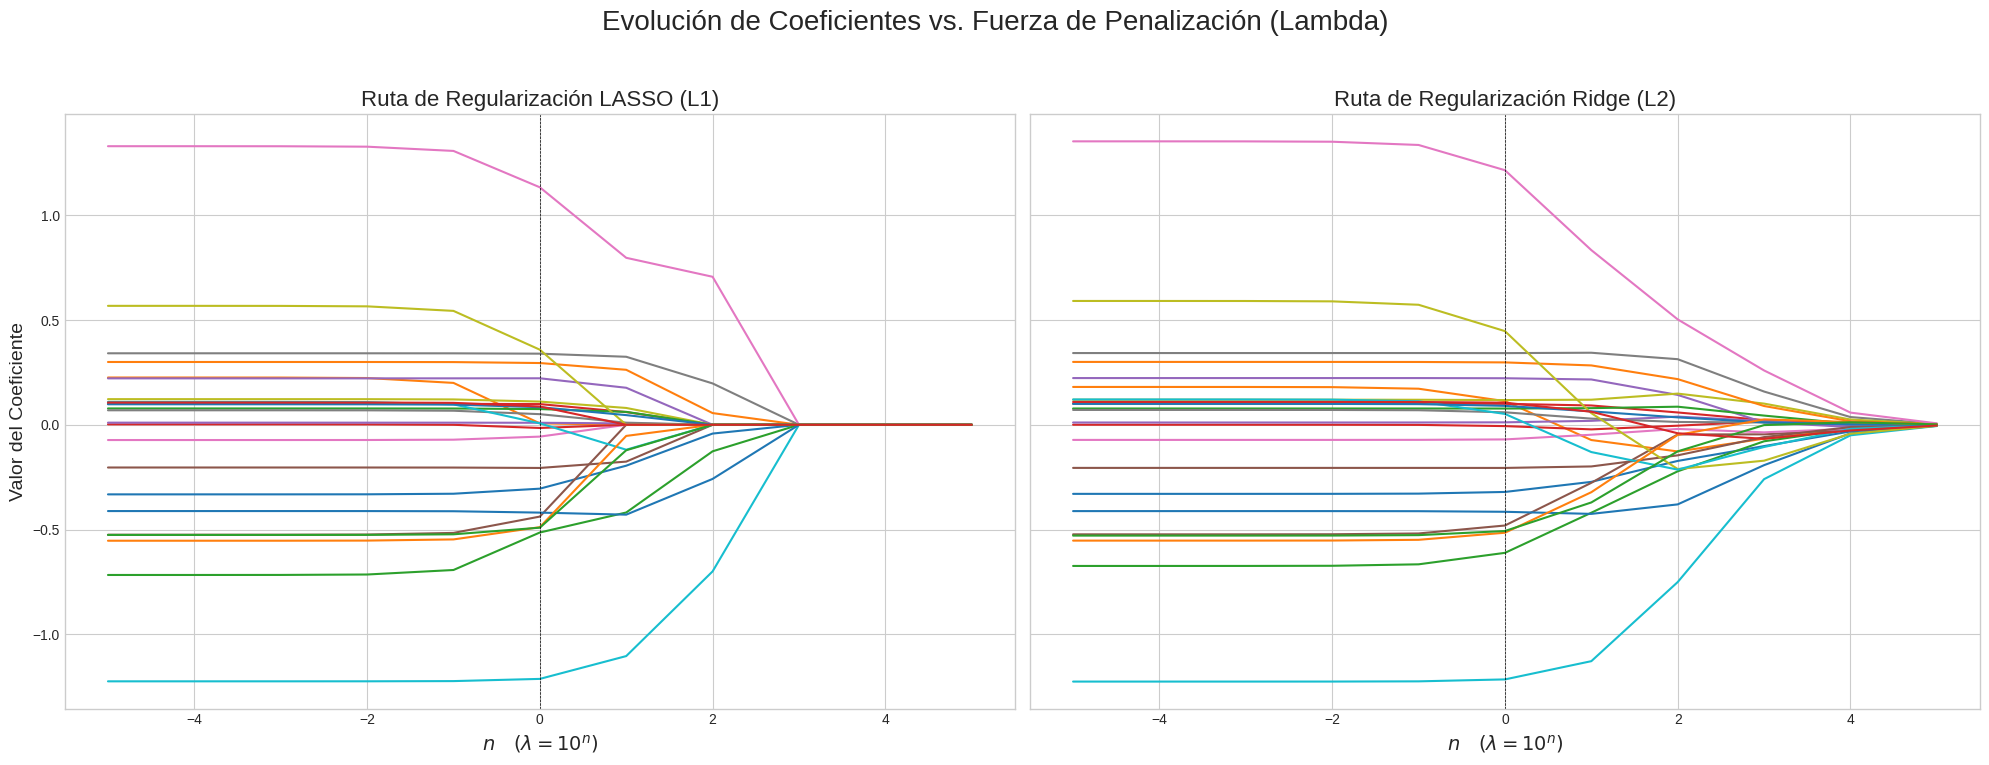

In [43]:
# Celda 6: Gráfico de Rutas de Regularización
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Eje X: usamos n_grid (que es log10(lambda))
x_axis = n_grid

# Panel 1: LASSO (L1)
# Usamos coefs_lasso de la Celda 4
for i in range(coefs_lasso.shape[1]):
    ax1.plot(x_axis, coefs_lasso[:, i], label=feature_names[i])
ax1.set_xlabel(r'$n \quad (\lambda = 10^n)$', fontsize=14)
ax1.set_ylabel('Valor del Coeficiente', fontsize=14)
ax1.set_title('Ruta de Regularización LASSO (L1)', fontsize=16)
ax1.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Panel 2: Ridge (L2)
for i in range(coefs_ridge.shape[1]):
    ax2.plot(x_axis, coefs_ridge[:, i], label=feature_names[i])
ax2.set_xlabel(r'$n \quad (\lambda = 10^n)$', fontsize=14)
ax2.set_title('Ruta de Regularización Ridge (L2)', fontsize=16)
ax2.axvline(0, color='black', linestyle='--', linewidth=0.5)

# Añadir leyenda (comentado porque hay 24 variables)
# if len(feature_names) <= 20:
#     ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Evolución de Coeficientes vs. Fuerza de Penalización (Lambda)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [44]:
# Celda 7: Búsqueda de Penalidad Óptima (L1 - LASSO)
# ==================================================
print("Iniciando 5-fold CV para LASSO (L1)...")

# Configuramos LogisticRegressionCV
# Usamos Cs=C_grid, cv=5, penalty='l1' y solver='liblinear'
logit_cv_l1 = LogisticRegressionCV(
    Cs=C_grid,
    penalty='l1',
    solver='liblinear',
    cv=5,
    scoring='accuracy', # Métrica de optimización
    random_state=42,
    max_iter=1000,
    n_jobs=-1 # Usar todos los cores
)

logit_cv_l1.fit(X_train_scaled, y_train)

# El C óptimo es logit_cv_l1.C_
# Convertimos de nuevo a lambda
lambda_opt_l1 = 1.0 / logit_cv_l1.C_[0]

print("CV para LASSO (L1) completado.")
print(f"El C óptimo seleccionado es: {logit_cv_l1.C_[0]:.6f}")
print(f"El Lambda (lambda_cv) óptimo correspondiente es: {lambda_opt_l1:.2f}")

Iniciando 5-fold CV para LASSO (L1)...
CV para LASSO (L1) completado.
El C óptimo seleccionado es: 0.100000
El Lambda (lambda_cv) óptimo correspondiente es: 10.00


In [45]:
# Celda 8: Búsqueda de Penalidad Óptima (L2 - Ridge)
# =================================================

print("Iniciando 5-fold CV para Ridge (L2)...")

# Configuramos LogisticRegressionCV
# Usamos Cs=C_grid, cv=5, penalty='l2' y solver='lbfgs'
logit_cv_l2 = LogisticRegressionCV(
    Cs=C_grid,
    penalty='l2',
    solver='lbfgs',
    cv=5,
    scoring='accuracy',
    random_state=42,
    max_iter=1000,
    n_jobs=-1
)

logit_cv_l2.fit(X_train_scaled, y_train)

# El C óptimo es logit_cv_l2.C_
lambda_opt_l2 = 1.0 / logit_cv_l2.C_[0]

print("CV para Ridge (L2) completado.")
print(f"El C óptimo seleccionado es: {logit_cv_l2.C_[0]:.6f}")
print(f"El Lambda (lambda_cv) óptimo correspondiente es: {lambda_opt_l2:.2f}")

Iniciando 5-fold CV para Ridge (L2)...
CV para Ridge (L2) completado.
El C óptimo seleccionado es: 0.100000
El Lambda (lambda_cv) óptimo correspondiente es: 10.00


In [46]:
# Celda 9: Preparación de Datos para Boxplots
# =======================================================================

# --- Verificación de Scores Promedio ---
# Extraemos los scores promedio para cada C (lambda)
scores_key_l1 = list(logit_cv_l1.scores_.keys())[0]
scores_key_l2 = list(logit_cv_l2.scores_.keys())[0]

mean_scores_l1 = np.mean(logit_cv_l1.scores_[scores_key_l1], axis=0)
mean_scores_l2 = np.mean(logit_cv_l2.scores_[scores_key_l2], axis=0)

# Creamos una tabla para comparar
df_scores = pd.DataFrame({
    'Lambda': lambda_grid,
    'Accuracy_Promedio_LASSO': mean_scores_l1,
    'Accuracy_Promedio_Ridge': mean_scores_l2
}).set_index('Lambda')

print("--- Verificación: Accuracy Promedio por Lambda (5-fold CV) ---")
display(df_scores.style.format('{:.6f}'))
print("--------------------------------------------------------------\n")

# --- Preparación de datos para Boxplots (código original) ---
# .scores_ es un diccionario por clase.
scores_l1 = logit_cv_l1.scores_[scores_key_l1]
scores_l2 = logit_cv_l2.scores_[scores_key_l2]

# Convertimos scores (accuracy) a error (1 - accuracy)
errors_l1 = 1 - scores_l1
errors_l2 = 1 - scores_l2

df_errors_l1 = pd.DataFrame(errors_l1, columns=lambda_grid)
df_errors_l2 = pd.DataFrame(errors_l2, columns=lambda_grid)

df_errors_l1_melted = df_errors_l1.melt(var_name='Lambda', value_name='Error de Validación')
df_errors_l2_melted = df_errors_l2.melt(var_name='Lambda', value_name='Error de Validación')

print("Datos de error por fold preparados para visualización.")

--- Verificación: Accuracy Promedio por Lambda (5-fold CV) ---


,Accuracy_Promedio_LASSO,Accuracy_Promedio_Ridge
Lambda,,
0.000010,0.786452,0.786119
0.000100,0.786452,0.786119
0.001000,0.786452,0.786119
0.010000,0.786452,0.786119
0.100000,0.786119,0.786119
1.000000,0.786452,0.786452
10.000000,0.789452,0.787455
100.000000,0.787122,0.786117
1000.000000,0.586253,0.771776


--------------------------------------------------------------

Datos de error por fold preparados para visualización.


/tmp/ipython-input-258289214.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_errors_l1_melted, x='Lambda', y='Error de Validación',
/tmp/ipython-input-258289214.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{l:g}' for l in lambda_grid], rotation=45)
/tmp/ipython-input-258289214.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_errors_l2_melted, x='Lambda', y='Error de Validación',
/tmp/ipython-input-258289214.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xt

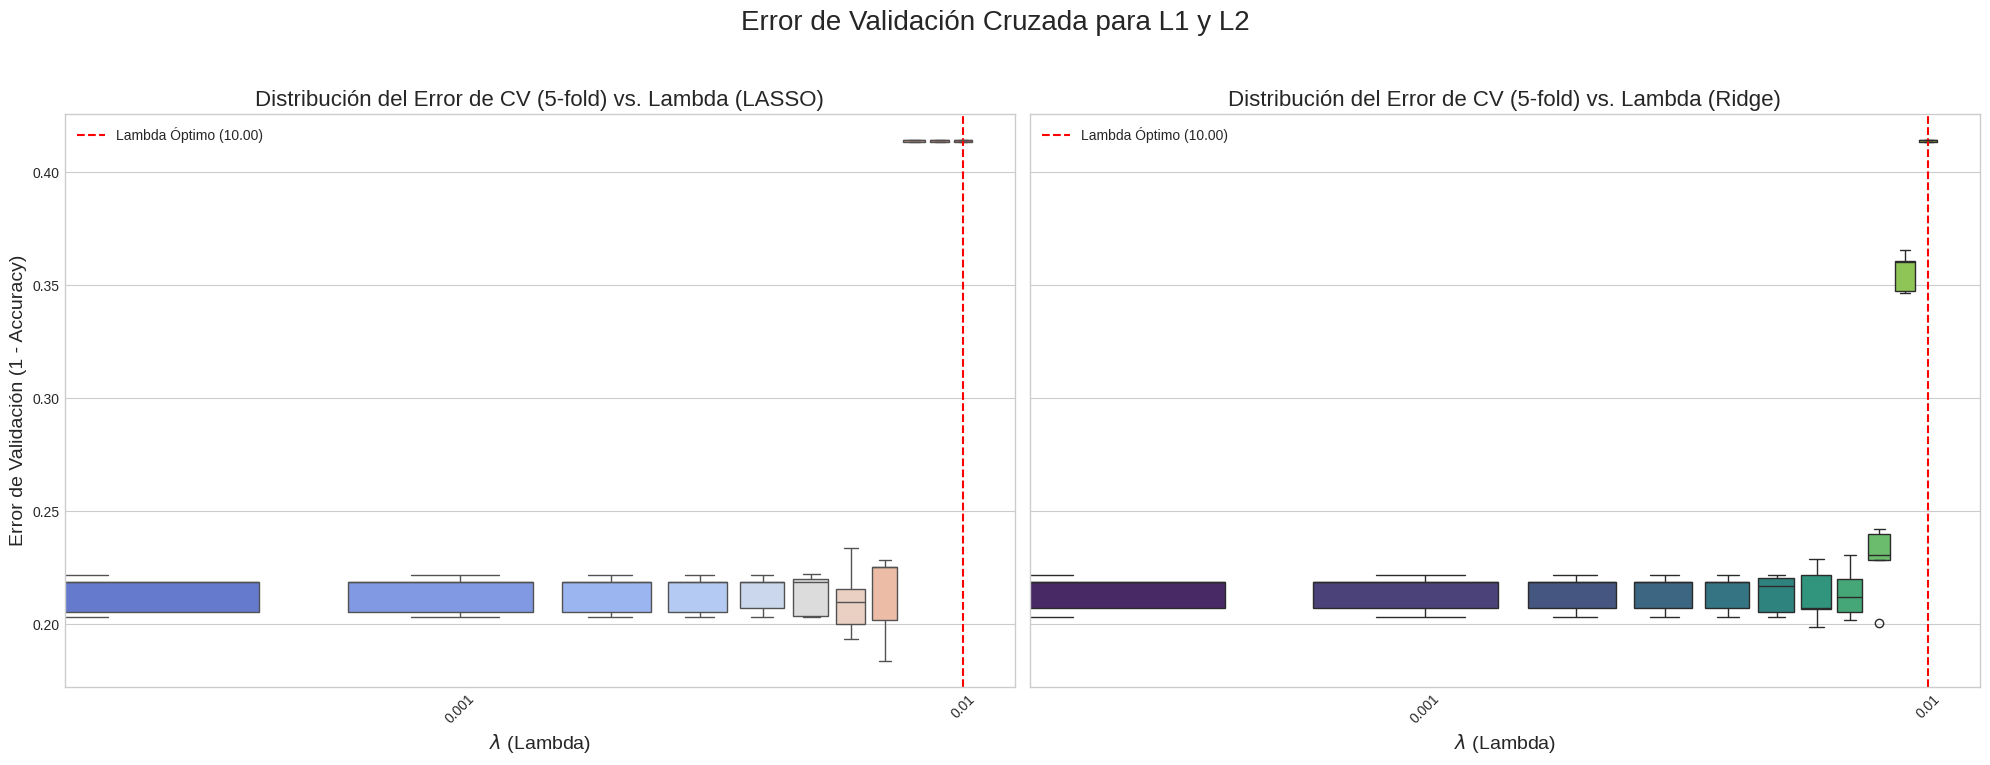

In [47]:
# Celda 10: Gráfico de Boxplots del Error de Validación
# ================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

palette_l1 = sns.color_palette("coolwarm", n_colors=len(lambda_grid))
palette_l2 = sns.color_palette("viridis", n_colors=len(lambda_grid))

# Panel 1: LASSO (L1)
sns.boxplot(data=df_errors_l1_melted, x='Lambda', y='Error de Validación',
            ax=ax1, palette=palette_l1, order=lambda_grid) # Asegura el orden
ax1.set_xlabel(r'$\lambda$ (Lambda)', fontsize=14)
ax1.set_ylabel('Error de Validación (1 - Accuracy)', fontsize=14)
ax1.set_title('Distribución del Error de CV (5-fold) vs. Lambda (LASSO)', fontsize=16)
ax1.set_xscale('log')
ax1.axvline(x=lambda_opt_l1, color='red', linestyle='--', label=f'Lambda Óptimo ({lambda_opt_l1:.2f})')
ax1.legend()

ax1.set_xticklabels([f'{l:g}' for l in lambda_grid], rotation=45)


# Panel 2: Ridge (L2)
sns.boxplot(data=df_errors_l2_melted, x='Lambda', y='Error de Validación',
            ax=ax2, palette=palette_l2, order=lambda_grid) # Asegura el orden
ax2.set_xlabel(r'$\lambda$ (Lambda)', fontsize=14)
ax2.set_ylabel('')
ax2.set_title('Distribución del Error de CV (5-fold) vs. Lambda (Ridge)', fontsize=16)
ax2.set_xscale('log')
ax2.axvline(x=lambda_opt_l2, color='red', linestyle='--', label=f'Lambda Óptimo ({lambda_opt_l2:.2f})')
ax2.legend()

ax2.set_xticklabels([f'{l:g}' for l in lambda_grid], rotation=45)


plt.suptitle('Error de Validación Cruzada para L1 y L2', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

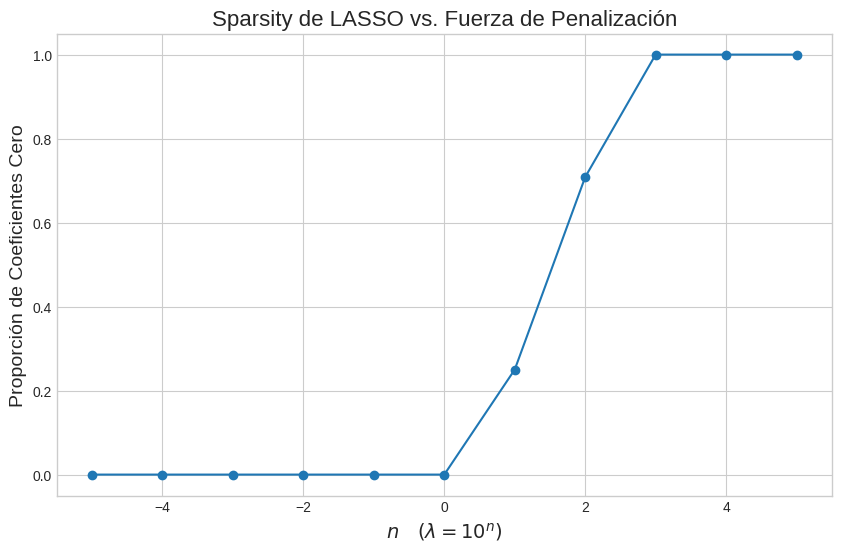

In [48]:
# Celda 11: Gráfico Sparsity (Dispersión) de LASSO
# =========================================================

# Calculamos la proporción de coeficientes que son exactamente 0
sparsity_l1 = [np.mean(coef_set == 0) for coef_set in coefs_lasso]

plt.figure(figsize=(10, 6))
plt.plot(n_grid, sparsity_l1, marker='o', linestyle='-')
plt.xlabel(r'$n \quad (\lambda = 10^n)$', fontsize=14)
plt.ylabel('Proporción de Coeficientes Cero', fontsize=14)
plt.title('Sparsity de LASSO vs. Fuerza de Penalización', fontsize=16)
plt.ylim(-0.05, 1.05) # Escala de 0% a 100%
plt.grid(True)
plt.show()

In [49]:
# Celda 12: Estimación de los Tres Modelos Logit
# =============================================

logit_no_pen = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
logit_no_pen.fit(X_train_scaled, y_train)
print("Modelo Logit sin penalidad entrenado.")

# 2. Logit L1 (LASSO) con C óptimo
# (Usamos el lambda_opt_l1 encontrado en la Celda 7)
c_opt_l1 = 1.0 / lambda_opt_l1
logit_l1_opt = LogisticRegression(
    penalty='l1',
    C=c_opt_l1,
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
logit_l1_opt.fit(X_train_scaled, y_train)
print("Modelo Logit L1 (óptimo) entrenado.")

# 3. Logit L2 (Ridge) con C óptimo
# (Usamos el lambda_opt_l2 encontrado en la Celda 8)
c_opt_l2 = 1.0 / lambda_opt_l2
logit_l2_opt = LogisticRegression(
    penalty='l2',
    C=c_opt_l2,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
logit_l2_opt.fit(X_train_scaled, y_train)
print("Modelo Logit L2 (óptimo) entrenado.")

Modelo Logit sin penalidad entrenado.
Modelo Logit L1 (óptimo) entrenado.
Modelo Logit L2 (óptimo) entrenado.


In [50]:
# Celda 13: Creación de la Tabla Comparativa de Coeficientes
# ==========================================================

# Extraemos los coeficientes (flatten() para convertirlos a 1D)
coefs_data = {
    'Coef_Logit_NoPen': logit_no_pen.coef_.flatten(),
    'Coef_Logit_L1_Opt': logit_l1_opt.coef_.flatten(),
    'Coef_Logit_L2_Opt': logit_l2_opt.coef_.flatten()
}

# Creamos el DataFrame
coefs_table = pd.DataFrame(coefs_data, index=feature_names)

coefs_table['Shrinkage_L1'] = (
    coefs_table['Coef_Logit_NoPen'].abs() - coefs_table['Coef_Logit_L1_Opt'].abs()
)
coefs_table['Shrinkage_L2'] = (
    coefs_table['Coef_Logit_NoPen'].abs() - coefs_table['Coef_Logit_L2_Opt'].abs()
)

print("Tabla comparativa de coeficientes generada.")

Tabla comparativa de coeficientes generada.


In [51]:
# Celda 14: Visualización de la Tabla de Coeficientes
# ===================================================
pd.set_option('display.float_format', '{:.6f}'.format)
display(coefs_table)

,Coef_Logit_NoPen,Coef_Logit_L1_Opt,Coef_Logit_L2_Opt,Shrinkage_L1,Shrinkage_L2
Educación,-0.329788,-0.195316,-0.272536,0.134472,0.057252
Edad,0.180624,0.000000,-0.072832,0.180624,0.107792
Edad 2,-0.673921,-0.418724,-0.419856,0.255197,0.254065
Sexo,0.100991,0.060648,0.092181,0.040343,0.008810
Es jefe,0.223012,0.176700,0.216343,0.046312,0.006669
Categoría ocupacional,-0.523030,0.000000,-0.277085,0.523030,0.245945
Horas trabajadas,-0.072203,0.000000,-0.047500,0.072203,0.024703
Adultos equivalentes,0.342427,0.324699,0.343902,0.017727,-0.001475
Ratio Dependencia,0.119738,0.080327,0.119658,0.039411,0.000080
Ocupados Share,-1.225896,-1.104181,-1.128498,0.121715,0.097398


# *Sección B*

In [52]:
# Celda 15: Obtención de la Ruta para podar
# =====================================================
# 1. Entrenar un árbol completo (sin podar) para encontrar la ruta
clf_unpruned = DecisionTreeClassifier(random_state=42)
clf_unpruned.fit(X_train_scaled, y_train)

# 2. Calcular la ruta de alfas efectivos
path = clf_unpruned.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas = path.ccp_alphas

# Removemos el último alfa, que corresponde al árbol trivial (el d un solo nodo)
ccp_alphas = ccp_alphas[:-1]

print(f"Se encontraron {len(ccp_alphas)} valores efectivos de ccp_alpha para la poda.")

Se encontraron 253 valores efectivos de ccp_alpha para la poda.


In [53]:
# Celda 16: Búsqueda del ccp_alpha Óptimo con GridSearchCV (10-fold)
# =================================================================
print("Iniciando 10-fold CV para encontrar ccp_alpha óptimo...")

# Definimos la grilla de parámetros a probar
param_grid = {'ccp_alpha': ccp_alphas}

# Configuramos GridSearchCV
grid_search_cart = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_cart.fit(X_train_scaled, y_train)

# El mejor estimador y el mejor alfa
cart_pruned = grid_search_cart.best_estimator_
optimal_ccp_alpha = grid_search_cart.best_params_['ccp_alpha']

print("CV para CART (10-fold) completado.")
print(f"El ccp_alpha óptimo seleccionado es: {optimal_ccp_alpha:.6f}")

Iniciando 10-fold CV para encontrar ccp_alpha óptimo...
CV para CART (10-fold) completado.
El ccp_alpha óptimo seleccionado es: 0.000923


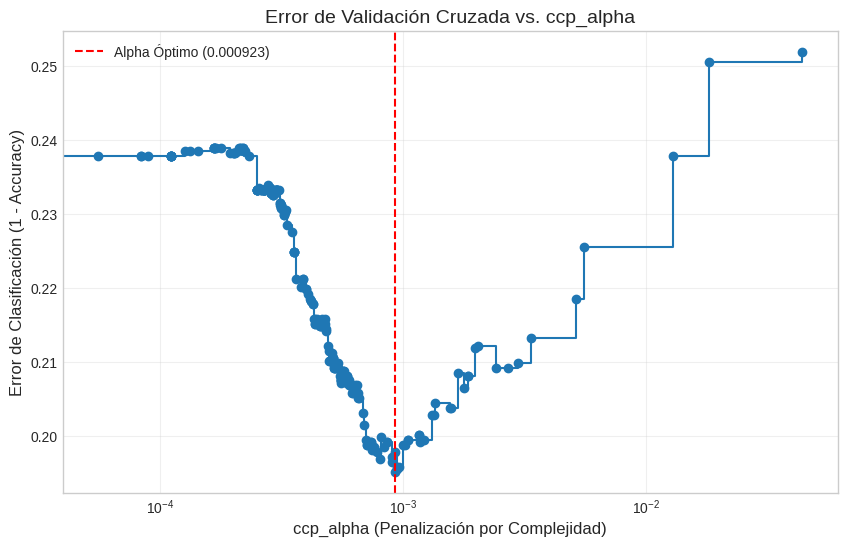

Comentario sobre los resultados (Ítem 4):
Observa el gráfico. A la izquierda (alphas bajos), el árbol es complejo (overfitting).
A la derecha (alphas altos), el árbol es muy simple (underfitting).
El punto óptimo busca balancear el sesgo y la varianza.


In [54]:
# Celda 17: Gráfico de Línea - Error de Clasificación vs. ccp_alpha
# ================================================================
# (ítem B.4)

# Extraemos los resultados del GridSearch
results = grid_search_cart.cv_results_
mean_test_scores = results['mean_test_score']

# La consigna pide graficar el ERROR de clasificación (1 - Accuracy)
mean_test_error = 1 - mean_test_scores

# Recuperamos los alphas que probamos (están en params)
# Nota: GridSearch puede no devolverlos en el mismo orden que ccp_alphas original,
# así que los extraemos de cv_results_ para asegurar correspondencia.
alphas_tested = [params['ccp_alpha'] for params in results['params']]

plt.figure(figsize=(10, 6))
plt.plot(alphas_tested, mean_test_error, marker='o', linestyle='-', drawstyle="steps-post")
plt.xlabel('ccp_alpha (Penalización por Complejidad)', fontsize=12)
plt.ylabel('Error de Clasificación (1 - Accuracy)', fontsize=12)
plt.title('Error de Validación Cruzada vs. ccp_alpha', fontsize=14)

# Marcamos el óptimo seleccionado
plt.axvline(
    optimal_ccp_alpha,
    color='red',
    linestyle='--',
    label=f'Alpha Óptimo ({optimal_ccp_alpha:.6f})'
)

plt.xscale('log') # Escala logarítmica ayuda si los alphas son muy pequeños
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Comentario sobre los resultados (Ítem 4):")
print("Observa el gráfico. A la izquierda (alphas bajos), el árbol es complejo (overfitting).")
print("A la derecha (alphas altos), el árbol es muy simple (underfitting).")
print("El punto óptimo busca balancear el sesgo y la varianza.")

Visualizando el árbol podado (ccp_alpha = 0.000923)
Profundidad: 12 | Hojas: 57


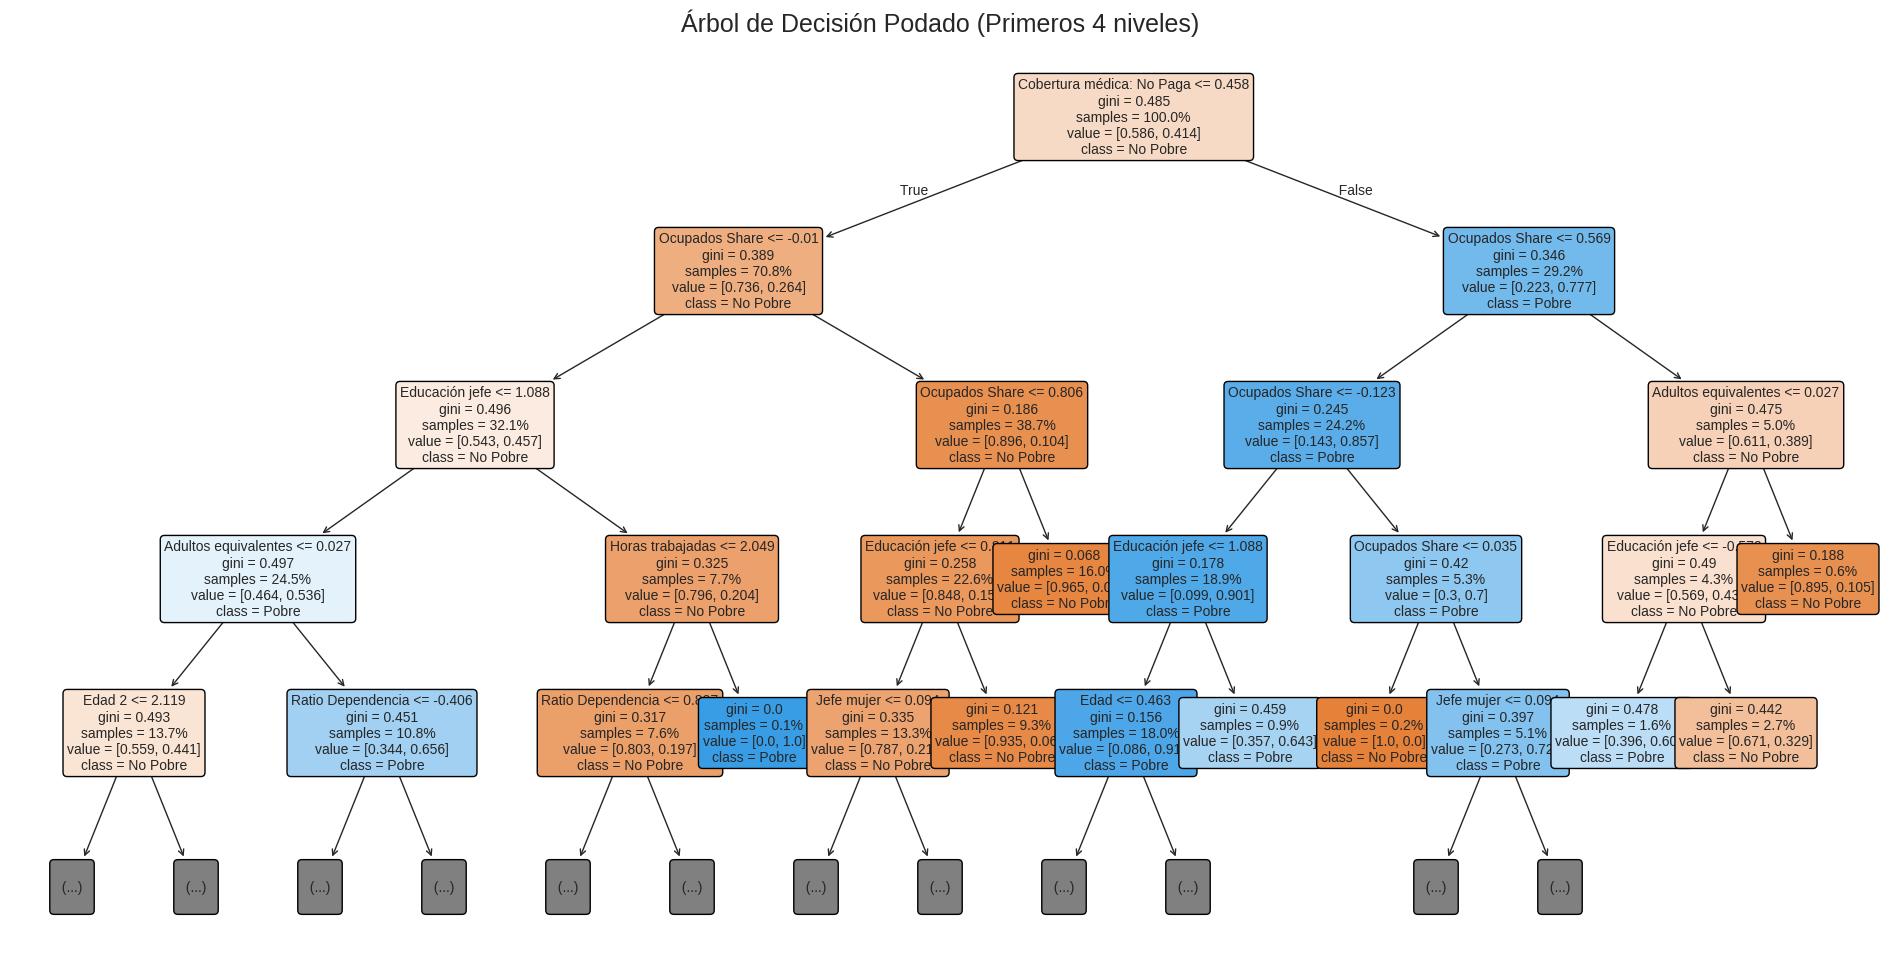

Nota: Si el árbol es muy profundo, 'max_depth=4' ayuda a la interpretación visual en el informe.


In [55]:
# Celda 18: Panel A - Visualización del Árbol Podado
# =================================================
# (B.5 Panel A)

print(f"Visualizando el árbol podado (ccp_alpha = {optimal_ccp_alpha:.6f})")
print(f"Profundidad: {cart_pruned.get_depth()} | Hojas: {cart_pruned.get_n_leaves()}")

# Definimos nombres de clases (0: No Pobre, 1: Pobre)
class_names = ['No Pobre', 'Pobre']

plt.figure(figsize=(24, 12)) # Figura grande para que se vea bien

plot_tree(
    cart_pruned,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,       # Colorear nodos según la clase mayoritaria (Gini)
    rounded=True,      # Bordes redondeados
    fontsize=10,       # Ajustar según la complejidad del árbol
    proportion=True,   # Mostrar proporciones en lugar de cuentas brutas (opcional)
    max_depth=4        # Limitamos la visualización a 4 niveles para que sea legible en el informe
)

plt.title(f'Árbol de Decisión Podado (Primeros 4 niveles)', fontsize=18)
plt.show()

print("Nota: Si el árbol es muy profundo, 'max_depth=4' ayuda a la interpretación visual en el informe.")

/tmp/ipython-input-2328929603.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


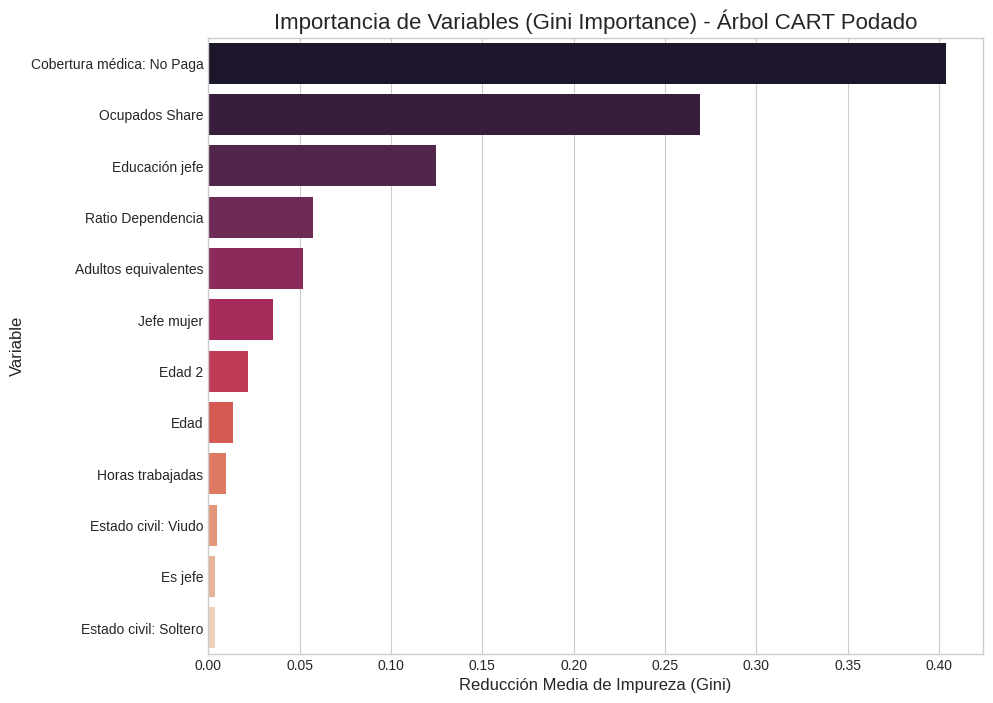

In [56]:
# Celda 19: Panel B - Gráfico de Importancia de Variables (Gini)
# =============================================================
# Extraemos la importancia de Gini
importances = cart_pruned.feature_importances_

# Creamos un DataFrame para visualizar [30, 31, 32]
importance_df = pd.DataFrame({
    'Variable': feature_names,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

# Filtramos solo las variables con importancia > 0
importance_df_filtered = importance_df[importance_df['Importancia'] > 0]

plt.figure(figsize=(10, 8))
sns.barplot(
    data=importance_df_filtered,
    x='Importancia',
    y='Variable',
    palette='rocket'
)
plt.title('Importancia de Variables (Gini Importance) - Árbol CART Podado', fontsize=16)
plt.xlabel('Reducción Media de Impureza (Gini)', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.show()

In [57]:
# Celda 20: Re-entrenamiento Modelos del TP3
# =================================================
# 1. Logit Base (TP3) - Ya entrenado en Celda 12 como 'logit_no_pen'

# 2. KNN (TP3)
# Usamos K optimo = 15 qie era el obtenido del TP3
K_OPT_TP3 = 15
knn_opt = KNeighborsClassifier(n_neighbors=K_OPT_TP3)
knn_opt.fit(X_train_scaled, y_train)

print("Modelos del TP3 (Logit Base, KNN) listos.")

# Los modelos del TP4 (logit_l1_opt, logit_l2_opt, cart_pruned) ya están entrenados.

Modelos del TP3 (Logit Base, KNN) listos.


In [58]:
# Celda 21: Generación de Predicciones y Probabilidades (Test Set)
# ===============================================================
# Diccionario de modelos finales
models_dict = {
    'Logit (TP3)': logit_no_pen,
    'KNN (TP3)': knn_opt,
    'Logit-LASSO (TP4)': logit_l1_opt,
    'Logit-Ridge (TP4)': logit_l2_opt,
    'CART (TP4)': cart_pruned
}

# Diccionarios para almacenar resultados
preds_dict = {}
probs_dict = {}

# Iteramos y predecimos sobre X_test_scaled
for name, model in models_dict.items():
    # Predicciones de clase (para p > 0.5)
    preds_dict[name] = model.predict(X_test_scaled)

    # Probabilidades de la clase positiva (Pobre=1)
    probs_dict[name] = model.predict_proba(X_test_scaled)[:, 1]

print("Predicciones generadas para los 5 modelos en el Test set.")

Predicciones generadas para los 5 modelos en el Test set.


In [59]:
# Celda 22: Cálculo de Métricas Consolidadas
# ==========================================

results_list = []

for name, y_pred in preds_dict.items():
    # Usamos classification_report con output_dict=True [33, 34]
    report = classification_report(y_test, y_pred, output_dict=True)

    # Obtenemos AUC
    auc = roc_auc_score(y_test, probs_dict[name])

    # Obtenemos Accuracy y Error
    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy

    # Métricas para la clase '1' (Pobre)
    recall_pobre = report['1']['recall']
    precision_pobre = report['1']['precision']
    f1_pobre = report['1']['f1-score']

    results_list.append({
        'Modelo': name,
        'AUC': auc,
        'Accuracy': accuracy,
        'Error (1-Acc)': error,
        'Recall (Pobre)': recall_pobre,
        'Precision (Pobre)': precision_pobre,
        'F1-Score (Pobre)': f1_pobre
    })

# Creamos la tabla final
results_table = pd.DataFrame(results_list).set_index('Modelo')

In [60]:
# Celda 23: Visualización de la Tabla de Métricas
# ==============================================
display(results_table.round(4))

,AUC,Accuracy,Error (1-Acc),Recall (Pobre),Precision (Pobre),F1-Score (Pobre)
Modelo,,,,,,
Logit (TP3),0.853700,0.777400,0.222600,0.652300,0.774600,0.708200
KNN (TP3),0.820400,0.749400,0.250600,0.607100,0.740800,0.667400
Logit-LASSO (TP4),0.854300,0.781300,0.218700,0.656000,0.780800,0.713000
Logit-Ridge (TP4),0.853900,0.778200,0.221800,0.654100,0.775100,0.709500
CART (TP4),0.862800,0.790700,0.209300,0.753800,0.744000,0.748800


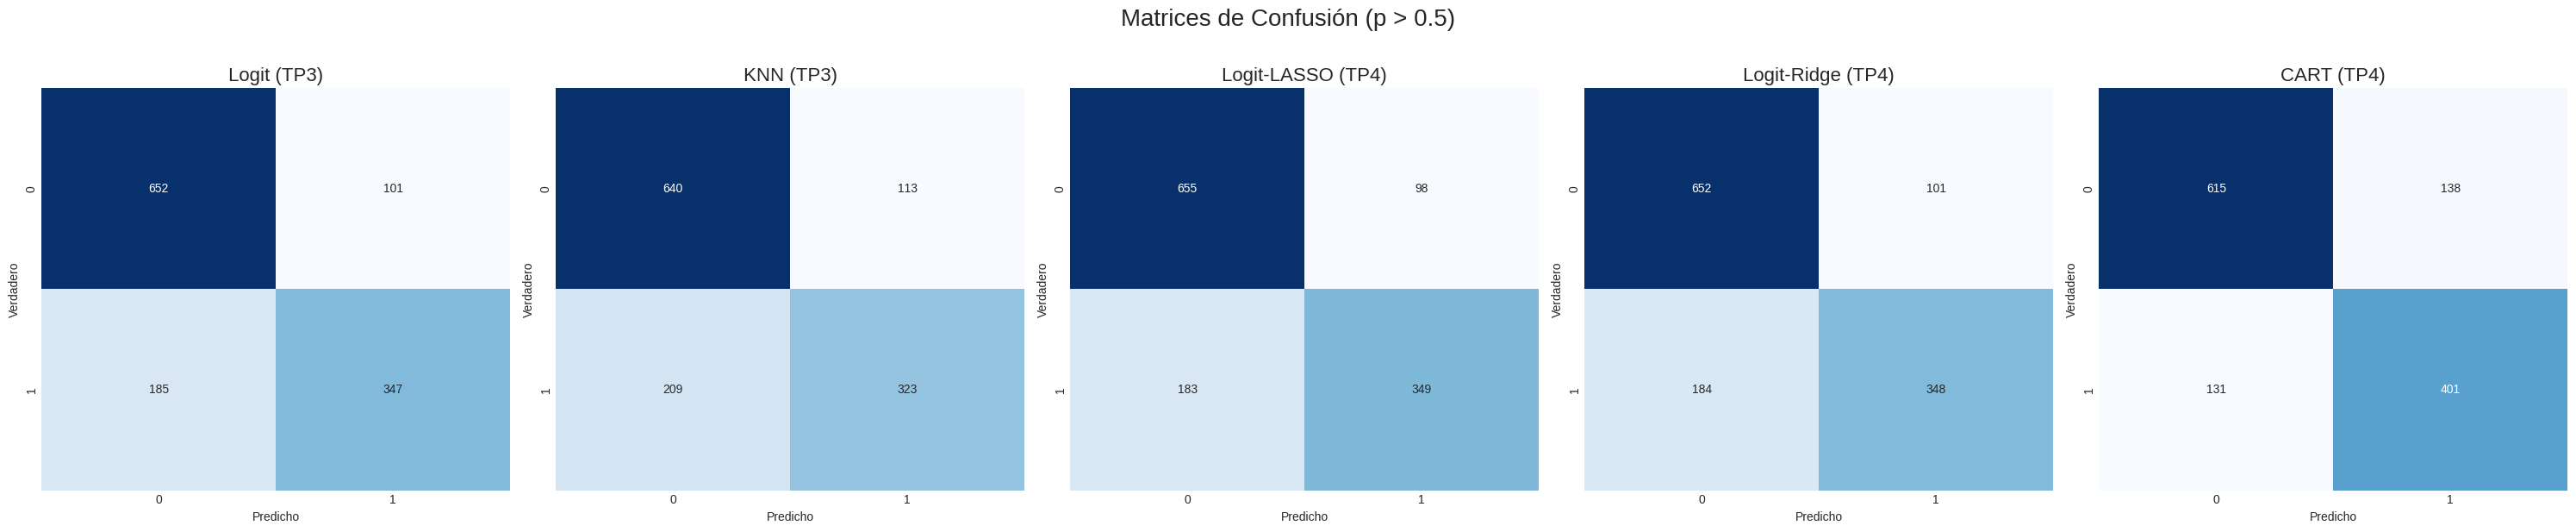

In [61]:
# Celda 24: Gráfico de Matrices de Confusión
# =========================================
fig, axes = plt.subplots(1, 5, figsize=(30, 6))

for i, (name, y_pred) in enumerate(preds_dict.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[i],
        cbar=False
    )
    axes[i].set_title(name, fontsize=16)
    axes[i].set_xlabel('Predicho')
    axes[i].set_ylabel('Verdadero')

plt.suptitle('Matrices de Confusión (p > 0.5)', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

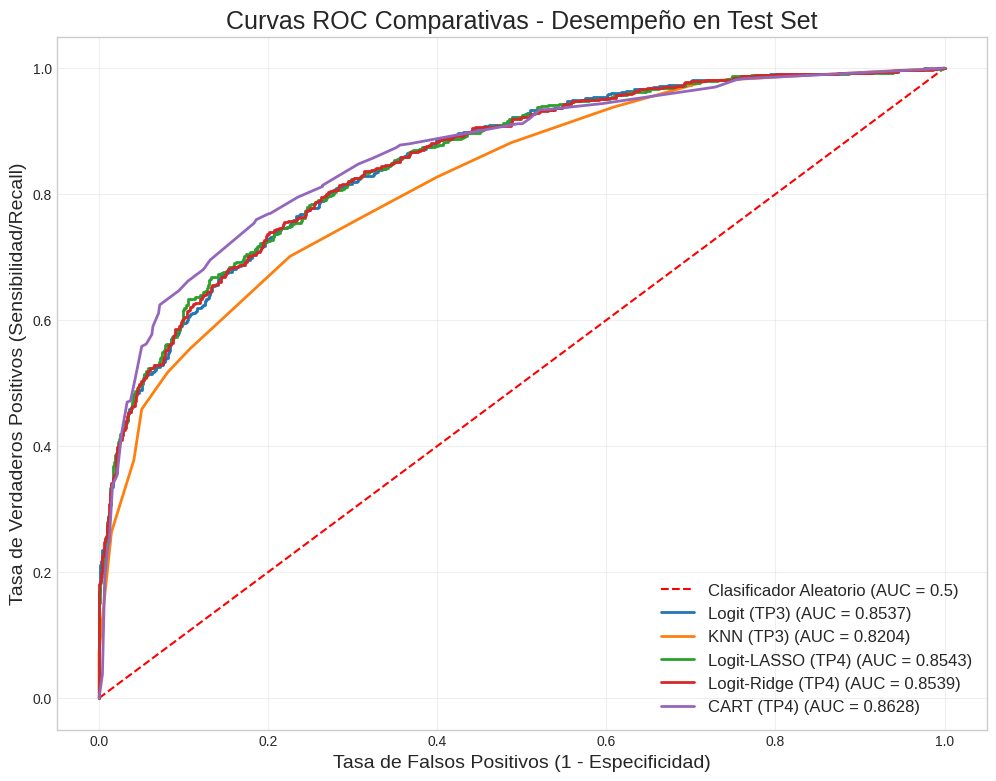

In [62]:
# Celda 25: Gráfico de Curvas ROC Comparativas
# ===========================================

plt.figure(figsize=(12, 9))

# Línea de azar
plt.plot([0, 1], [0, 1], 'r--', label='Clasificador Aleatorio (AUC = 0.5)')

# Iteramos sobre los modelos guardados
for name, y_prob in probs_dict.items():
    # Calcular FPR, TPR
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Calcular AUC (ya lo tenemos en results_table, pero lo usamos de ahí)
    auc = results_table.loc[name, 'AUC']

    # Graficar
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad/Recall)', fontsize=14)
plt.title('Curvas ROC Comparativas - Desempeño en Test Set', fontsize=18)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()